In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lf
from lifelines.utils.sklearn_adapter import sklearn_adapter


import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

In [2]:
# let's get our data
# 434 -> stroke
# 428 -> heart failure
# 425 -> cardiomyopathy

data = pd.read_csv('clean/afib_434_4_clean.csv')
T, E = data['duration'], data['event']
columns = data.columns
data.describe()

,duration,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
count,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000
mean,1188.200612,0.769237,75.335637,0.411354,0.588646,0.394394,0.041536,0.079224,0.040829,0.000314,0.004790,0.438913
std,777.870643,0.421338,10.957782,0.492098,0.492098,0.488739,0.199534,0.270099,0.197902,0.017720,0.069044,0.496274
min,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,544.000000,1.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1099.000000,1.000000,77.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1754.000000,1.000000,83.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3289.000000,1.000000,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
data.head()

,duration,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,1807.0,1.0,62.0,0,1,1,0,0,0,0,0,0
1,1071.0,1.0,79.0,0,1,0,0,0,1,0,0,0
2,1686.0,1.0,88.0,0,1,1,0,0,0,0,0,0
3,1814.0,1.0,81.0,0,1,1,0,0,0,0,0,0
4,307.0,1.0,67.0,1,0,0,0,1,0,0,0,0


In [4]:
data.shape[0] # number of patients

12736

In [5]:
censorship_counts = data['event'].value_counts()
censor_rate = censorship_counts[0] / censorship_counts.sum()
print('Censor Rate:', str(round(censor_rate, 2)*100) + '%')

Censor Rate: 23.0%


In [6]:
censorship_counts

1.0    9797
0.0    2939
Name: event, dtype: int64

In [7]:
X = pd.DataFrame(data.drop('duration', axis=1))
Y = pd.DataFrame(data['duration'])

X['age'] = preprocessing.scale(X['age'])
X

,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
0,1.0,-1.217049,0,1,1,0,0,0,0,0,0
1,1.0,0.334421,0,1,0,0,0,1,0,0,0
2,1.0,1.155787,0,1,1,0,0,0,0,0,0
3,1.0,0.516946,0,1,1,0,0,0,0,0,0
4,1.0,-0.760735,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12731,0.0,1.247050,0,1,0,0,0,0,0,0,1
12732,0.0,1.064524,1,0,0,0,0,0,0,0,1
12733,0.0,-0.304420,0,1,1,0,0,0,0,0,0
12734,0.0,0.060632,1,0,0,0,1,0,0,0,0


In [8]:
trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainX.columns = columns[1:] 
valX.columns = columns[1:]

### Linear Regression

In [9]:
lrg = LinearRegression()
lrg.fit(trainX, trainY)
print(lf.utils.concordance_index(valY, lrg.predict(valX), event_observed=valX['event']))

0.5780556108728925


### Cox Regression

In [10]:
CoxRegression = sklearn_adapter(lf.CoxPHFitter, event_col='event')
sk_cph = CoxRegression(penalizer=.1)

sk_cph.fit(trainX, trainY)
sk_cph.lifelines_model.print_summary()

In [11]:
sk_cph.score(valX, valY)

0.6321627177642114

In [12]:
'''
cph = lf.CoxPHFitter(penalizer=.1)
cph.fit(data, 'duration','event')
cph.check_assumptions(data)
'''

"\ncph = lf.CoxPHFitter(penalizer=.1)\ncph.fit(data, 'duration','event')\ncph.check_assumptions(data)\n"

In [13]:
#sk_cph.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

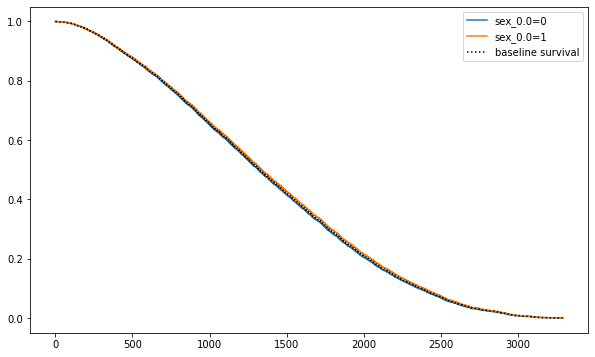

In [14]:
sk_cph.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Weibull AFT

In [15]:
'''
# get best parameters for WeibullAFT
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')
sk_wf = WeibullAFT()

clf = model_selection.GridSearchCV(sk_wf, {
    "penalizer":10.0 ** np.arange(-2, 3),
    "l1_ratio": [0, 1/3, 2/3],
    "model_ancillary":[True,False],
}, cv=4)
clf.fit(trainX, trainY)
print(clf.best_estimator_)
'''

'\n# get best parameters for WeibullAFT\nWeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col=\'event\')\nsk_wf = WeibullAFT()\n\nclf = model_selection.GridSearchCV(sk_wf, {\n    "penalizer":10.0 ** np.arange(-2, 3),\n    "l1_ratio": [0, 1/3, 2/3],\n    "model_ancillary":[True,False],\n}, cv=4)\nclf.fit(trainX, trainY)\nprint(clf.best_estimator_)\n'

In [16]:
WeibullAFT = sklearn_adapter(lf.WeibullAFTFitter, event_col='event')

sk_wf = WeibullAFT(penalizer=.1)
sk_wf.fit(trainX, trainY)
sk_wf.lifelines_model.print_summary()

In [17]:
sk_wf.score(valX, valY)

0.6323162528819704

In [18]:
sk_wf.lifelines_model.mean_survival_time_

1360.7925907076403

In [19]:
sk_wf.lifelines_model.median_survival_time_

1274.409861145408

In [20]:
#sk_wf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

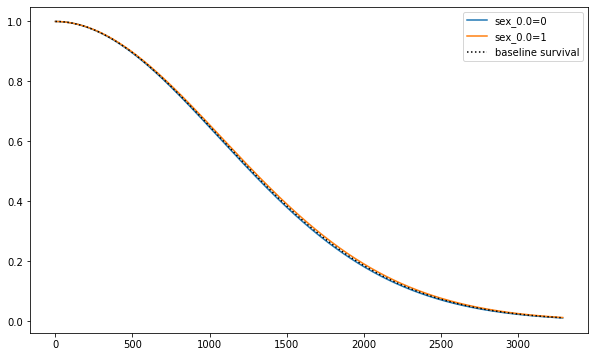

In [21]:
sk_wf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Log-Normal AFT

In [22]:
LogNormAFT = sklearn_adapter(lf.LogNormalAFTFitter, event_col='event')

sk_lnf = LogNormAFT()
sk_lnf.fit(trainX, trainY)
sk_lnf.lifelines_model.print_summary()

In [23]:
sk_lnf.score(valX, valY)

0.6330907270737651

In [24]:
sk_lnf.lifelines_model.mean_survival_time_

1504.9707191467878

In [25]:
sk_lnf.lifelines_model.median_survival_time_

1153.2109298532937

In [26]:
#sk_lnf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

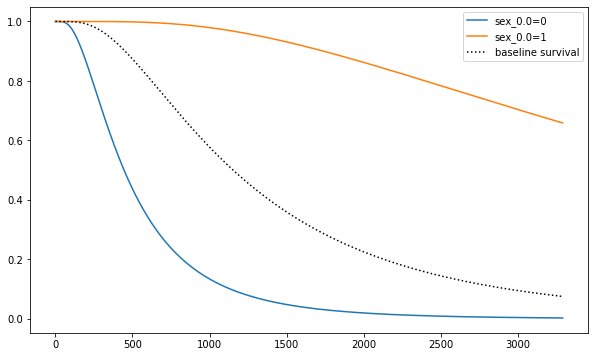

In [27]:
sk_lnf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Log-Logistic AFT

In [28]:
LogLogAFT = sklearn_adapter(lf.LogLogisticAFTFitter, event_col='event')

sk_llf = LogLogAFT()
sk_llf.fit(trainX, trainY)
sk_llf.lifelines_model.print_summary()

In [29]:
sk_llf.score(valX, valY)

0.6330575838841382

In [30]:
sk_llf.lifelines_model.mean_survival_time_

1588.9168165814424

In [31]:
sk_llf.lifelines_model.median_survival_time_

1227.403930421691

In [32]:
#sk_llf.lifelines_model.plot_covariate_groups('pos', values=[0,1], figsize=(10,6))

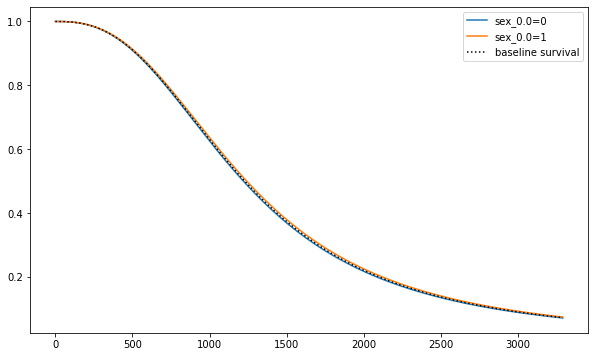

In [33]:
sk_llf.lifelines_model.plot_covariate_groups('sex_0.0', values=[0,1], figsize=(10,6))

### Compare AFTs

In [34]:
print('Weibull:', sk_wf.lifelines_model.log_likelihood_)
print('Log-Norm:', sk_lnf.lifelines_model.log_likelihood_)
print('Log-Log:', sk_llf.lifelines_model.log_likelihood_)

Weibull: -59154.206146257886
Log-Norm: -60137.48607483803
Log-Log: -59760.922789175485


### Aalen's Additive Regression

In [35]:
aff = lf.AalenAdditiveFitter(coef_penalizer=.05)
aff.fit(data, duration_col='duration', event_col='event')
aff.print_summary()

### K-Fold Cross-Validation

##### Aalen's

In [36]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.AalenAdditiveFitter(coef_penalizer=.1), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Weibull AFT

In [37]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.WeibullAFTFitter(), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

##### Cox

In [38]:
#print(np.mean(lf.utils.k_fold_cross_validation(lf.CoxPHFitter(penalizer=.05), data, duration_col='duration', event_col='event', scoring_method='concordance_index')))

### scikit-survival models

In [39]:
'''
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")
'''

'\n%matplotlib inline\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas\nimport seaborn as sns\nfrom sklearn.model_selection import ShuffleSplit, GridSearchCV\n\nfrom sksurv.datasets import load_veterans_lung_cancer\nfrom sksurv.column import encode_categorical\nfrom sksurv.metrics import concordance_index_censored\nfrom sksurv.svm import FastSurvivalSVM\n\nsns.set_style("whitegrid")\n'

In [40]:
'''
data['event'] = data['event'].astype(bool)
X = pd.DataFrame(data.drop(['duration','event'], axis=1))
Y = pd.DataFrame(data[['event','duration']])

X['age'] = preprocessing.scale(X['age'])

trainX, valX, trainY, valY = model_selection.train_test_split(X, Y)
trainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)

trainY = trainY.to_records(index=False)

valY = valY.to_records(index=False)

trainX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9']
valX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9'] 
'''

"\ndata['event'] = data['event'].astype(bool)\nX = pd.DataFrame(data.drop(['duration','event'], axis=1))\nY = pd.DataFrame(data[['event','duration']])\n\nX['age'] = preprocessing.scale(X['age'])\n\ntrainX, valX, trainY, valY = model_selection.train_test_split(X, Y)\ntrainX, valX, trainY, valY = pd.DataFrame(trainX), pd.DataFrame(valX), pd.DataFrame(trainY), pd.DataFrame(valY)\n\ntrainY = trainY.to_records(index=False)\n\nvalY = valY.to_records(index=False)\n\ntrainX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9']\nvalX.columns=['age','c1','c2','s1','s2','r1','r2','r3','r4','r5','r6','r9'] \n"

##### Cox variation with elastic net penalty

In [41]:

#from sksurv.linear_model import CoxnetSurvivalAnalysis

#cphnet = CoxnetSurvivalAnalysis()
#cphnet.fit(trainX, trainY)

In [42]:
#cphnet.score(valX, valY)

##### sksurv's Cox implementation

In [43]:
#from sksurv.linear_model import CoxPHSurvivalAnalysis

#cph = CoxPHSurvivalAnalysis()
#pd.Series(cph.fit(trainX, trainY))

In [44]:
#cphnet.score(valX, valY)